In [ ]:
import pandas as pd 
import numpy as np
import pickle
import matplotlib.pyplot as plt
import random
import copy
from collections import defaultdict
from sklearn.model_selection import train_test_split
import math
np.random.seed(1234)
import random
import seaborn as sns

In [1]:
import pystan

ModuleNotFoundError: No module named 'pystan'

2.19.1.1

In [6]:
# Data generating function
seed=[i for i in range(10)]
def generate_data(vi_dim, num_data, max_num_emb, v,seed):
    np.random.seed(seed)
    Vi = np.random.randn(num_data, vi_dim) + v
    beta = np.random.normal(loc=0, scale=0.15, size=(vi_dim,))
    beta0 = np.mean(Vi @ beta.T)
    
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))
    vib=-beta0 + Vi @ beta.T
    proba = sigmoid(vib)
    y = np.random.binomial(1, proba)
    true_y=np.round(proba,0)
    
    E = []
    for V in Vi:
        ni = np.random.randint(1, max_num_emb + 1)
        ei = np.random.normal(V, 0.5, (ni, vi_dim))
        E.append(ei)
    
    #Split the data
    X_train, X_test, y_train, y_test, train_vib, test_vib,train_vi,test_vi= train_test_split(E, y,vib, Vi,test_size=0.2, random_state=42)
    
    #li=[X_train, X_test, y_train, y_test, beta, beta0, maximum_auc,vib]
    data=[X_train, X_test, y_train, y_test, beta, beta0, 0,Vi,train_vi,test_vi,train_vib,test_vib]
    #print("Data has been stored")
    
    plt.hist(Vi @ beta.T, bins=10)
    plt.xlabel("vi*beta")
    plt.show()
    
    plt.hist(proba)
    plt.xlabel("Probability of occurrence")
    plt.show()
    return data


In [7]:
logistic_code = """
data {
  int<lower=0> N;
  int<lower=0> K;
  matrix[N, K] X;
  int<lower=0,upper=1> y[N];
  int<lower=0> N_new;
  matrix[N_new, K] X_new;
}

parameters {
  vector[K] beta;
  real alpha;
}

model {
  y ~ bernoulli_logit(alpha + X * beta);
}
generated quantities {
  vector[N_new] y_new_prob;
  for (i in 1:N_new) {
    y_new_prob[i] = inv_logit(alpha + X_new[i, ] * beta); 
  }
}"""

In [3]:
logistic_code = """
functions {
  // count number times elem appears in test set
  int count_elem(int[] test, int elem) {
    int count;
    count = 0;
    for(i in 1:num_elements(test))
      if(test[i] == elem)
        count = count + 1;
    return(count);
  }

  // find elements in test which are equal to elem
  int[] which_elem(int[] test, int elem) {
    int res[count_elem(test, elem)];
    int ci;
    ci = 1;
    for(i in 1:num_elements(test))
      if(test[i] == elem) {
        res[ci] = i;
        ci = ci + 1;
      }
    return(res);
  }

}


data {
  int<lower=0> n;
  int<lower=0> N;
  int<lower=0> D;
  matrix[N, D] E;
  int<lower=0,upper=1> y[n];
  int Ids[N];
  real<lower=0> Sigmav2;
  real<lower=0> Sigmae2;
  real<lower=0> Sigmab2;
}

parameters {
  vector[D] beta;
  matrix[n, D] v;
}

model {  
  target += bernoulli_lpmf(y | to_vector(v * beta));
  target += normal_lpdf(to_vector(v) | 0, Sigmav2);
  for (i in 1:n) {
    int Ids_i[count_elem(Ids, i)] = which_elem(Ids, i);
    matrix[n_i, D] E_i = E[Ids_i, ];
    int<lower=0> n_i = size(Ids_i);
    for (j in 1:n_i) {
      target += normal_lpdf(to_vector(E_i[j, ]) | to_vector(v[i, ]), Sigmae2);
    }
  }
  target += normal_lpdf(beta | 0, Sigmab2);
}
generated quantities {

}"""

In [4]:
result=[]

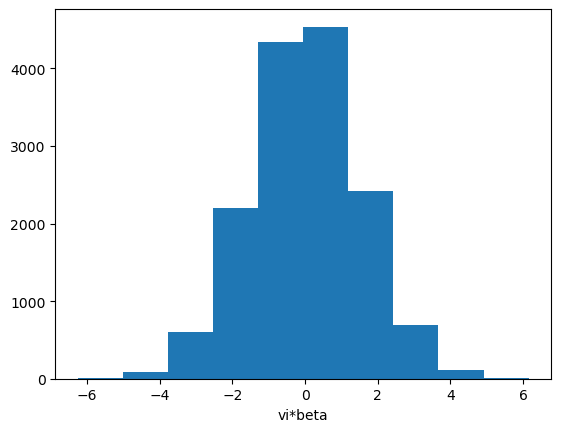

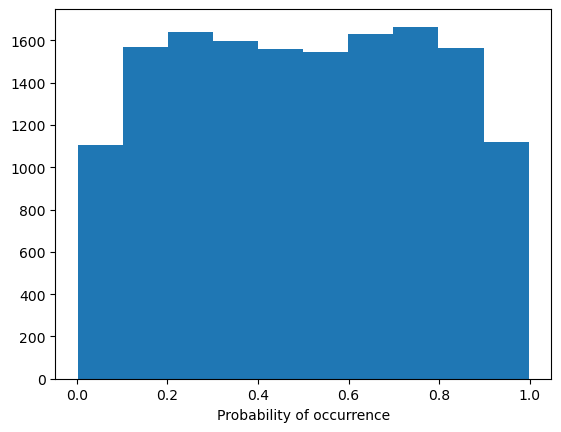

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_9c790fc25e3230be11700945b78708bf NOW.
In file included from /hpc/home/zm91/.conda/envs/ehr/lib/python3.9/site-packages/numpy/core/include/numpy/ndarraytypes.h:1929,
                 from /hpc/home/zm91/.conda/envs/ehr/lib/python3.9/site-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /hpc/home/zm91/.conda/envs/ehr/lib/python3.9/site-packages/numpy/core/include/numpy/arrayobject.h:5,
                 from /tmp/pystan_3frgu_ku/stanfit4anon_model_9c790fc25e3230be11700945b78708bf_9117129320042255669.cpp:1315:
/hpc/home/zm91/.conda/envs/ehr/lib/python3.9/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
   17 | #warning "Using deprecated NumPy API, disable it with " \
      |  ^~~~~~~
In file included from /hpc/home/zm91/.conda/envs/ehr/lib/python3.9/site-packages/p


Gradient evaluation took 0.188395 seconds
1000 transitions using 10 leapfrog steps per transition would take 1883.95 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.206648 seconds
1000 transitions using 10 leapfrog steps per transition would take 2066.48 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.186406 seconds
1000 transitions using 10 leapfrog steps per transition would take 1864.06 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.186443 seconds
1000 transitions using 10 leapfrog steps per transition would take 1864.43 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 1000 [  0%]  (Warmup)
Iteration:   1 / 1000 [  0%]  (Warmup)
Iteration:   1 / 1000 [  0%]  (Warmup)
Iteration:   1 / 1000 [  0%]  (Warmup)


Process ForkPoolWorker-5:
Traceback (most recent call last):
  File "/hpc/home/zm91/.conda/envs/ehr/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/hpc/home/zm91/.conda/envs/ehr/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/hpc/home/zm91/.conda/envs/ehr/lib/python3.9/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/hpc/home/zm91/.conda/envs/ehr/lib/python3.9/multiprocessing/queues.py", line 365, in get
    res = self._reader.recv_bytes()
  File "/hpc/home/zm91/.conda/envs/ehr/lib/python3.9/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/hpc/home/zm91/.conda/envs/ehr/lib/python3.9/multiprocessing/connection.py", line 414, in _recv_bytes
    buf = self._recv(4)
  File "/hpc/home/zm91/.conda/envs/ehr/lib/python3.9/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
Ke

In [ ]:
logistic_code = """
functions {
  // count number times elem appears in test set
  int count_elem(int[] test, int elem) {
    int count;
    count = 0;
    for (i in 1:num_elements(test))
      if (test[i] == elem)
        count = count + 1;
    return(count);
  }

  // find elements in test which are equal to elem
  int[] which_elem(int[] test, int elem) {
    int res[count_elem(test, elem)];
    int ci;
    ci = 1;
    for (i in 1:num_elements(test))
      if (test[i] == elem) {
        res[ci] = i;
        ci = ci + 1;
      }
    return(res);
  }
}

data {
  int<lower=0> n;
  int<lower=0> N;
  int<lower=0> D;                   
  matrix[N, D] E;
  int<lower=0, upper=1> y[n];
  int Ids[N];
  real<lower=0> Sigmav2;
  real<lower=0> Sigmae2;
  real<lower=0> Sigmab2;
}

parameters {
  vector[D] beta;
  matrix[n, D] v;
}

model {
  target += bernoulli_logit_lpmf(y | to_vector(v * beta));
  target += normal_lpdf(to_vector(v) | 0, Sigmav2);

  for (i in 1:n) {
    int n_i = count_elem(Ids, i);             
    int Ids_i[n_i] = which_elem(Ids, i);      
    matrix[n_i, D] E_i = E[Ids_i, ];          
    for (j in 1:n_i) {
      target += normal_lpdf(to_vector(E_i[j, ]) | to_vector(v[i, ]), Sigmae2);  
    }
  }
  target += normal_lpdf(beta | 0, Sigmab2);
}

generated quantities {
}
"""
for i in range(10):
    num_data = 15000
    vi_dim = 100
    max_num_emb = 50
    v = 0  

    X_train, X_test, y_train, y_test, beta, beta0, _, Vi, train_vi, test_vi, train_vib, test_vib = generate_data(vi_dim, num_data, max_num_emb, v, seed=i)
    train_indices = random.sample(range(len(X_train)), 800)
    X_train = [X_train[i] for i in train_indices]  
    y_train = [y_train[i] for i in train_indices]  

    test_indices = random.sample(range(len(X_test)), 200)  
    X_test= [X_test[i] for i in test_indices]  
    y_test= [y_test[i] for i in test_indices]  

    n = 1000
    N = sum(len(e) for e in X_train + X_test)
    D = vi_dim
    E = np.vstack(X_train + X_test)
    y = np.concatenate([y_train, y_test])
    Ids = np.concatenate([[i+1] * len(X_train[i]) for i in range(len(X_train))] + 
                         [[800 + i + 1] * len(X_test[i]) for i in range(len(X_test))])
    Sigmav2 = 1.0
    Sigmae2 = 0.5
    Sigmab2 = 0.15

    data = {
        'n': n,
        'N': N,
        'D': D,
        'E': E,
        'y': y,
        'Ids': Ids,
        'Sigmav2': Sigmav2,
        'Sigmae2': Sigmae2,
        'Sigmab2': Sigmab2
    }

    posterior = pystan.StanModel(model_code=logistic_code)
    fit = posterior.sampling(data=data, iter=250, chains=4,n_jobs=5)
    beta_samples = fit.extract()['beta']
    #V_samples = fit.extract()['v'] 
    with open(f'bay_beta{i}.pkl','wb') as f:
        pickle.dump(beta_samples,f)
    result.append(beta_samples)


In [8]:
with open(f'bay_beta0.pkl','rb') as f:
        result=pickle.load(f)

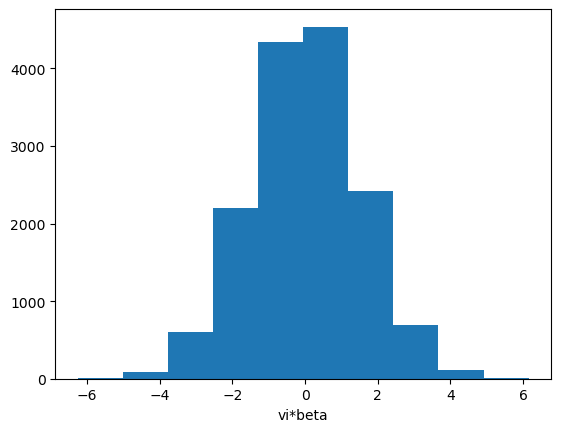

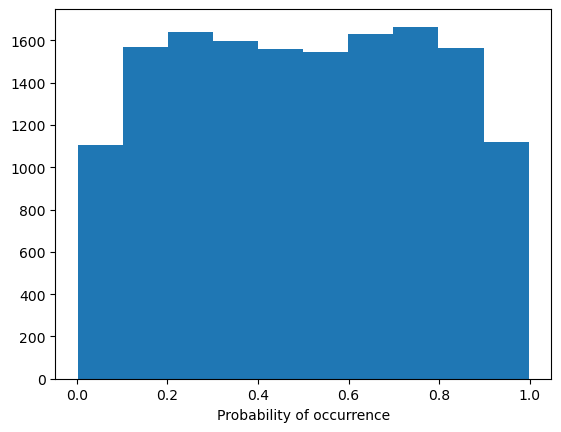

In [10]:
num_data = 15000
vi_dim = 100
max_num_emb = 50
i = 0  

X_train, X_test, y_train, y_test, beta, beta0, _, Vi, train_vi, test_vi, train_vib, test_vib = generate_data(vi_dim, num_data, max_num_emb, 0, seed=i)


n = num_data
N = sum(len(e) for e in X_train + X_test)
D = vi_dim
E = np.vstack(X_train + X_test)
y = np.concatenate([y_train, y_test])

In [11]:
n = np.array([len(X_test[i]) for i in range(len(X_test))])
beta_0=result[1] 

In [9]:
S = 2000
M = 2000
sigma_e2 = 0.5**2
sigma_v2 = 1.0**2

beta_samples = result[0][0][:S]
V_samples = result[0][1][:S]

e_list = X_train+X_test

pred_probs = []
vi=[]
sigma=[]
mu=[]
for e_i in e_list:
    n_i = e_i.shape[0]
    mu_i = np.sum(e_i, axis=0) / (n_i + (sigma_e2 / sigma_v2))
    variance = sigma_e2 / (n_i + (sigma_e2 / sigma_v2))
    v_i_samples = mu_i + np.random.normal(0, np.sqrt(variance), (M, mu_i.shape[0]))
    mu.append(mu_i)
    sigma.append(variance)
    vi.append(v_i_samples)
    v_i_beta_products = np.dot(v_i_samples, beta_samples.T)
    probs = 1 / (1 + np.exp(-v_i_beta_products))
    pred_prob = np.mean(probs)
    
    pred_probs.append(pred_prob)


beta samples 500*100, vi samples 500*100, log odds

In [54]:
M = 1000
sigma_e2 = 0.5
sigma_v2 = 1.0

beta_samples = result[1][0] 
num_sample=len(beta_samples)
e_list = X_train + X_test

pred_probs = []
vi = []
sigma = []
mu = []
vib = []

for e_i in e_list:
    n_i = e_i.shape[0]
    
    mu_i = np.sum(e_i, axis=0) / (n_i + (sigma_e2 / sigma_v2))
    variance = sigma_e2 / (n_i + (sigma_e2 / sigma_v2))
    
    v_i_samples = mu_i + np.random.normal(0, np.sqrt(variance), (M, mu_i.shape[0]))
    mu.append(mu_i)
    sigma.append(variance)
    vi.append(v_i_samples)
    
    beta_samples_subset = beta_samples[np.random.choice(num_sample, M, replace=False), :] 
    #beta_samples_subset = beta_samples[1, :] 
    
    v_i_beta_products = np.sum(v_i_samples * beta_samples_subset, axis=1)  
    
    vib.append(v_i_beta_products)
    
    probs = 1 / (1 + np.exp(-v_i_beta_products))
    pred_prob = np.mean(probs)  
    
    pred_probs.append(pred_prob)


In [16]:
M = 2000
sigma_e2 = 0.5**2
sigma_v2 = 1.0**2

beta_samples = result[0] 
num_sample=len(beta_samples)
e_list =  X_test

pred_probs = []
vi = []
sigma = []
mu = []
vib = []

for e_i in e_list:
    n_i = e_i.shape[0]
    
    mu_i = np.sum(e_i, axis=0) / (n_i + (sigma_e2 / sigma_v2))
    variance = sigma_e2 / (n_i + (sigma_e2 / sigma_v2))
    
    v_i_samples = mu_i + np.random.normal(0, np.sqrt(variance), (M, mu_i.shape[0]))
    mu.append(mu_i)
    sigma.append(variance)
    vi.append(v_i_samples)
    i=np.random.choice(num_sample, M, replace=True)
    beta_samples_subset = beta_samples[i,:] 
    beta_0_samples=beta_0[i]
    #beta_samples_subset = beta_samples[1, :] 
    
    v_i_beta_products = np.sum(v_i_samples * beta_samples_subset, axis=1) 
    
    vib.append(v_i_beta_products+beta_0_samples)
    
    probs = 1 / (1 + np.exp(-vib[-1]))
    pred_prob = np.mean(probs)  
    pred_probs.append(pred_prob)


In [17]:
from sklearn.metrics import roc_auc_score
#np.mean(np.round(pred_probs)==y_test)
roc_auc_score(y_test,pred_probs)

0.770038792214534

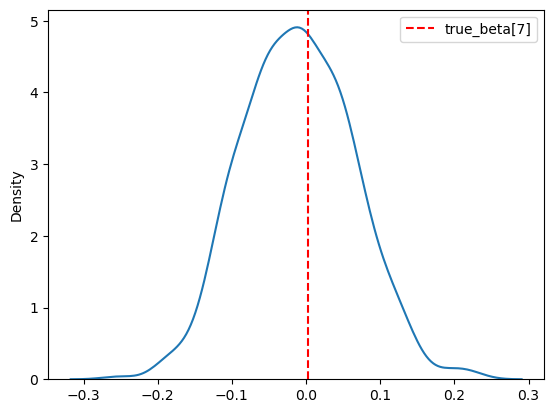

In [23]:
def parameter_dist(true_beta, beta_samples, i):
    sns.kdeplot(beta_samples[:, i])
    plt.axvline(x=true_beta[i], color='red', linestyle='--', label=f'true_beta[{i}]')
    plt.legend()
    plt.show()
parameter_dist(beta,beta_samples,7)

/tmp/ipykernel_683756/3036335376.py:3: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


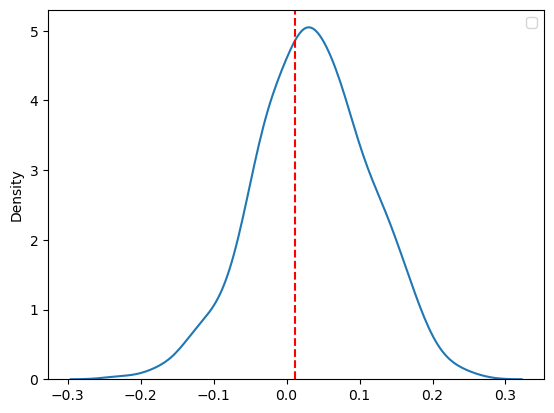

In [24]:
sns.kdeplot(beta_0)
plt.axvline(x=beta0, color='red', linestyle='--')
plt.legend()
plt.show() 

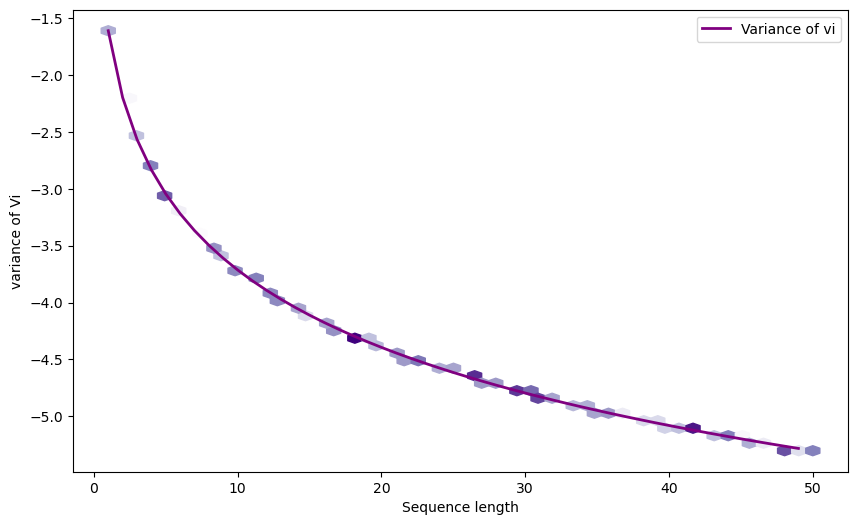

In [25]:
variance_vi=np.array([i for i in sigma])
unique_n=np.array([i for i in range(1,50)])
mean_log_var = [np.mean(variance_vi[n == x]) for x in unique_n]
plt.figure(figsize=(10, 6))
plt.hexbin(n, np.log(variance_vi), gridsize=50, cmap='Purples', mincnt=2, alpha=0.999)
plt.plot(unique_n,np.log(mean_log_var), color='purple', lw=2, label='Variance of vi')

plt.xlabel("Sequence length")
plt.ylabel("variance of Vi")
plt.legend()
plt.show()

Text(0, 0.5, 'log odds')

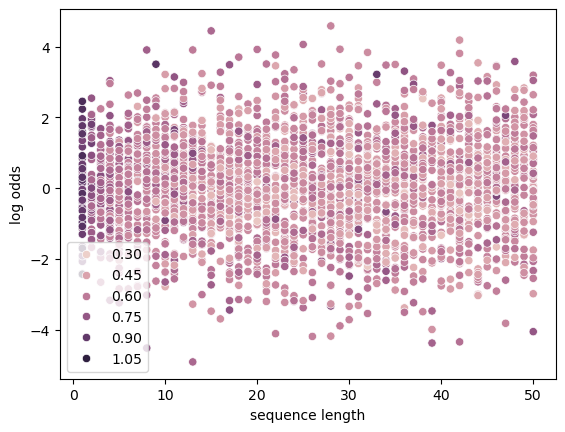

In [26]:
unique_n=np.array([i for i in range(1,50)])
var=np.array([np.var(i,axis=0) for i in vib])
vib_mean=np.array([np.mean(i,axis=0) for i in vib])
n=n.flatten()
sns.scatterplot(x=n, y=vib_mean, hue=var)
plt.xlabel("sequence length")
plt.ylabel("log odds")

In [27]:
beta_mu=np.mean(beta)

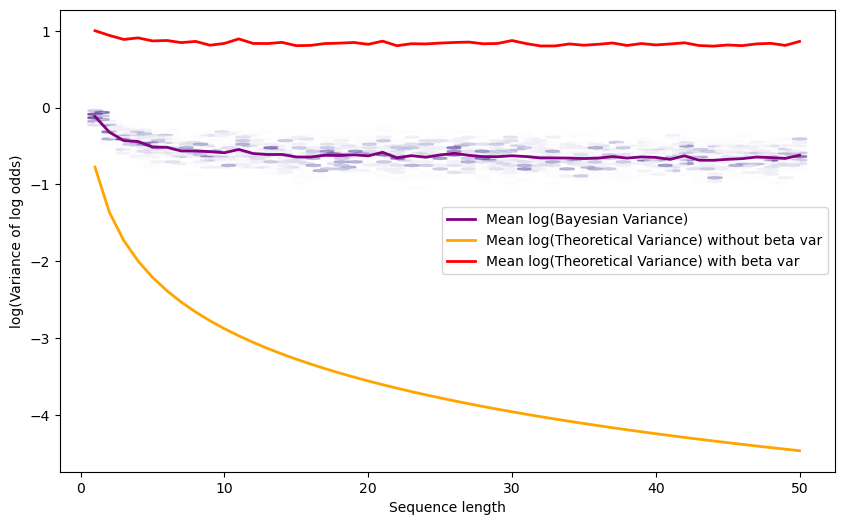

In [30]:
sum_beta_square=sum([beta[i]**2 for i in range(100)])
unique_n=[i for i in range(1,51)]
mean_log_var = [np.mean(np.log(var)[n == x]) for x in unique_n]
mean_log_var_std = [np.mean(np.log(np.array(sigma)*sum_beta_square)[n == x]) for x in unique_n]
mean_log_var_std2 = [np.mean(np.log(np.array(var_std_lo))[n == x]) for x in unique_n]
plt.figure(figsize=(10, 6))
plt.hexbin(n, np.log(var), gridsize=50, cmap='Purples', mincnt=2, alpha=0.6)
plt.plot(unique_n, mean_log_var, color='purple', lw=2, label='Mean log(Bayesian Variance)')
plt.plot(unique_n, mean_log_var_std, color='orange', lw=2, label='Mean log(Theoretical Variance) without beta var')
plt.plot(unique_n, mean_log_var_std2, color='red', lw=2, label='Mean log(Theoretical Variance) with beta var')
plt.xlabel("Sequence length")
plt.ylabel("log(Variance of log odds)")
plt.legend()
plt.show()